In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ase.units import Hartree,Bohr
from scipy.special import struve,yn
from itertools import product
from tqdm import tqdm
from scipy.sparse.linalg import eigsh
import numba

a=3.193 # lattice parameter
volume=a/Bohr**2*np.sqrt(3)/2
t=1.10  # effective hopping parameter
delta=1.66  # gap
epsilon=1 # substrate dielectric contant
r0=33.875/epsilon # screening length
tau=1 # valley index
N=60 # brillouin zone mesh
kmax=0.41 # reciprocal vector cutoff
number_of_states=4 # number of exciton states for visualization

s1=np.array([[0,1],
             [1,0]])
s2=np.array([[0,-1j],
             [1j,0]])
s3=np.array([[1,0],
             [0,-1]])
s0=np.array([[1,0],
             [0,1]])
alpha=4.075/epsilon

In [3]:
def keldysh_potential_real(r):
    return Hartree*Bohr*np.pi/(2*epsilon*r0)*(struve(0,r/r0)-yn(0,r/r0))

def keldysh_potential_reciprocal(q):
    return Hartree*Bohr*2*np.pi/epsilon/q/(1+r0*q)

def dirac_hamiltonian(kx,ky,tau=1):
    return a*t*(tau*kx*s1+ky*s2)+delta/2*s3

@numba.njit()
def exciton_hamiltonian(HS,E,D,D_conj,WK,indexes):
    NS=HS.shape[0]
    for i in range(NS):
        x1,y1=indexes[i]
        HS[i,i]+=E[x1,y1,1]-E[x1,y1,0]
        for j in range(NS):
            x2,y2=indexes[j]
            overlap_c=np.sum(D[x1,y1,1].conj()*D[x2,y2,1])
            overlap_v=np.sum(D[x2,y2,0].conj()*D[x1,y1,0])
            HS[i,j]-=WK[(x1-x2)%N,(y1-y2)%N]*overlap_c*overlap_v
    return HS

a1=np.array([a, 0. ])
a2=np.array([-a/2,a*np.sqrt(3)/2])

cell=np.array([a1,a2])
icell=2*np.pi*np.linalg.inv(cell).T

k1=icell[0]
k2=icell[1]

R=np.zeros((N,N,2))
K=np.zeros((N,N,2))
WR=np.zeros((N,N))
for i in range(N):
    for j in range(N):
        R[i,j]=a1*(i-N/2)+a2*(j-N/2)
        K[i,j]=k1*(i-N/2)/N+k2*(j-N/2)/N
        WR[i,j]=keldysh_potential_real(np.linalg.norm(R[i,j])) 

# evaluating W(0)
W0=0
corrections=10
for i in range(corrections):
    WR[int(N/2),int(N/2)]=W0     
    WK=np.abs(np.fft.fft2(np.fft.fftshift(WR)))/N/N
    W0=np.sum(WK)

E=np.zeros((N,N,2))
D=np.zeros((N,N,2,2),dtype=complex)
H=np.zeros((N,N,2,2),dtype=complex)
for i in range(N):
    for j in range(N):
        H[i,j]=dirac_hamiltonian(K[i,j,0],K[i,j,1])
        e,d=np.linalg.eigh(H[i,j])
        E[i,j]=e;D[i,j]=d

indexes=[]
for i in range(N):
    for j in range(N):
        if np.linalg.norm(K[i,j])<kmax:
            indexes.append((i,j))
NS=len(indexes)

HS=np.zeros((NS,NS),dtype=complex)
HS=exciton_hamiltonian(HS,E,D,D.conj(),WK,indexes)


/usr/local/lib/python3.7/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'indexes' of function 'exciton_hamiltonian'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-3-4befe1ac1ce4>", line 11:
@numba.njit()
def exciton_hamiltonian(HS,E,D,D_conj,WK,indexes):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


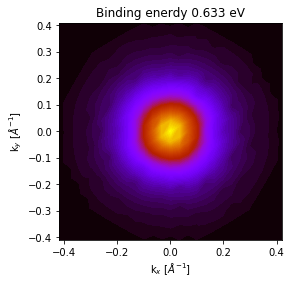

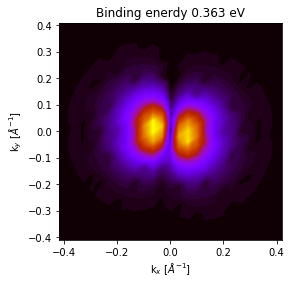

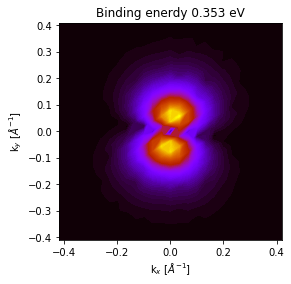

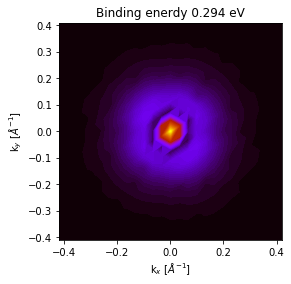

In [5]:
number_of_states=4
ES,DS=eigsh(HS,which='SA',k=number_of_states)
for state in range(number_of_states):
    if ES[state]<delta:
        plt.figure(figsize=(4,4))
        wave=np.zeros((N,N))
        for i,index in enumerate(indexes):
            x,y=index
            wave[x,y]=np.abs(DS[i,state])
        plt.contourf(K[:,:,0],K[:,:,1],wave,100,cmap='gnuplot')
        plt.axis('equal')
        plt.xlim([-kmax,kmax])
        plt.ylim([-kmax,kmax])
        plt.title('Binding enerdy {:.{prec}f} eV'.format(delta-ES[state],prec=3))
        plt.xlabel('k$_x$ [$\AA^{-1}$]')
        plt.ylabel('k$_y$ [$\AA^{-1}$]')
        plt.savefig('figures/'+str(state)+'.png',dpi=600)

In [6]:
ES,DS=np.linalg.eigh(HS)

(-0.41, 0.41)

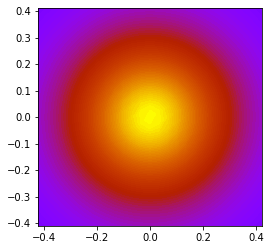

In [8]:
P=np.zeros((N,N),dtype=complex)
for i in range(N):
    for j in range(N):
        P[i,j]=a*t*np.dot(D[i,j,:,1].T.conj(),np.dot(s1+1j*s2,D[i,j,:,0]))/Hartree/Bohr*tau
PS=np.array([P[i,j] for i,j in indexes])

plt.figure(figsize=(4,4))
plt.contourf(K[:,:,0],K[:,:,1],np.abs(P)**2,100,cmap='gnuplot')
plt.axis('equal')
plt.xlim([-kmax,kmax])
plt.ylim([-kmax,kmax])

In [9]:
OS=np.abs(np.sum(DS*PS[:,None],axis=0))**2 

In [10]:
w=np.linspace(0,2*delta,1001);eta=0.02
chi=np.zeros(w.size,dtype=complex)
chi0=np.zeros(w.size,dtype=complex)
for i in range(NS):
    chi+=2*OS[i]/(w-ES[i]+1j*eta)/NS*Hartree
    chi-=2*OS[i]/(w+ES[i]+1j*eta)/NS*Hartree
for i in range(N):
    for j in range(N):
        chi0+=2*np.abs(P[i,j])**2/(w-(E[i,j,1]-E[i,j,0])+1j*eta)/N/N*Hartree
        chi0-=2*np.abs(P[i,j])**2/(w+(E[i,j,1]-E[i,j,0])+1j*eta)/N/N*Hartree
fxc=1/chi0-1/chi

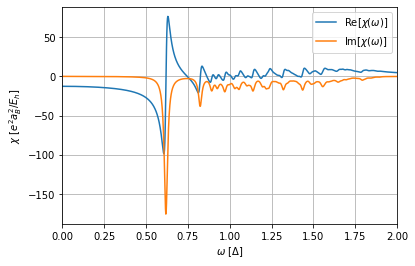

In [11]:
plt.plot(w/delta,chi.real,label='Re[$\chi(\omega)$]')
plt.plot(w/delta,chi.imag,label='Im[$\chi(\omega)$]')
plt.grid()
plt.xlim([0,2])
plt.legend()
plt.xlabel('$\omega$ [$\Delta$]')
plt.ylabel('$\chi$ [$e^2 a^2_B / E_h$]')
plt.savefig('figures/chi.png',dpi=600)

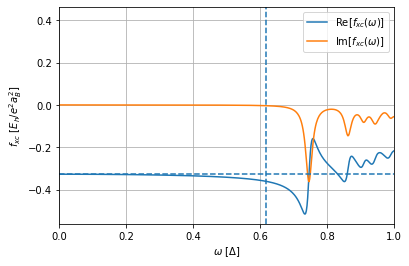

In [16]:
plt.plot(w/delta,fxc.real,label='Re[$f_{xc}(\omega)$]')
plt.plot(w/delta,fxc.imag,label='Im[$f_{xc}(\omega)$]')
plt.axhline(fxc[0].real,linestyle='--')
plt.axvline(ES[0]/delta,linestyle='--')
plt.grid()
plt.xlim([0,1])
# plt.ylim([-0.4,-0.3])
plt.legend()
plt.xlabel('$\omega$ [$\Delta$]')
plt.ylabel('$f_{xc}$ [$E_h/e^2a^2_B$]')
plt.savefig('figures/fxc.png',dpi=600)

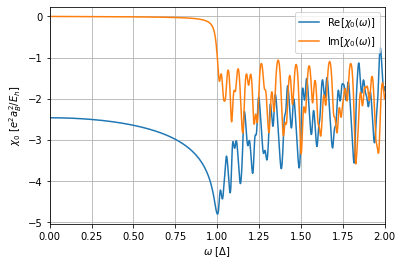

In [13]:
plt.plot(w/delta,chi0.real,label='Re[$\chi_0(\omega)$]')
plt.plot(w/delta,chi0.imag,label='Im[$\chi_0(\omega)$]')
plt.grid()
plt.xlim([0,2])
plt.legend()
plt.xlabel('$\omega$ [$\Delta$]')
plt.ylabel('$\chi_0$ [$e^2 a^2_B / E_h$]')
plt.savefig('figures/chi_0.png',dpi=600)

In [14]:
chi_test_1=chi0/(1+0.36*chi0)
chi_test_2=chi0/(1+0.325*chi0)

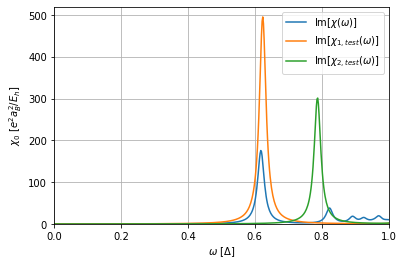

In [17]:
plt.plot(w/delta,-chi.imag,label='Im[$\chi(\omega)$]')
plt.plot(w/delta,-chi_test_1.imag,label='Im[$\chi_{1,test}(\omega)$]')
plt.plot(w/delta,-chi_test_2.imag,label='Im[$\chi_{2,test}(\omega)$]')
plt.grid()
plt.xlim([0,1])
plt.ylim([0,None])
plt.legend()
plt.xlabel('$\omega$ [$\Delta$]')
plt.ylabel('$\chi_0$ [$e^2 a^2_B / E_h$]')
plt.savefig('figures/chi_0.png',dpi=600)